<div align="center">
    <font size=7>TME 1: Sélection de modèles et arbres de décisions
    </font>
</div>
<br/>
<div align="right">
    <font size=3>SERRAF Dan & KOSTADINOVIC Nikola
    </font>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pydotplus
import copy
from collections import Counter
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

### Q1.1

In [2]:
def entropie(vect):
    """
    numpy.ndarray -> numpy.float64
    """
    valeurs = np.array(list(Counter(vect).values()))
    proba = valeurs / vect.size
    return sum(proba * np.log(proba)) * - 1

vect = np.array([1,2,1,4,3])
print(entropie(vect))

1.3321790402101223


### Q1.2

In [3]:
def entropie_cond(list_vect):
    """
    numpy.ndarray -> numpy.float64
    """
    resultat = 0.
    total = 0.
    for vect in list_vect :
        resultat += vect.size * entropie(vect)
        total += vect.size
    return resultat / total

vect = np.array([[1,2,4,3],[1,2,4,3]])
print(entropie_cond(vect))

1.3862943611198906


### Q1.3

In [4]:
# data : tableau (films ,features), id2titles : dictionnaire id -> titre , # fields : id feature -> nom
[data, id2titles, fields] = pickle.load(open("./imdb_extrait.pkl_/imdb_extrait.pkl","rb"))

# la derniere colonne est le vote
datax=data[:,:32]
datay=np.array([1 if x[33]>6.5 else -1 for x in data])
print(datax.shape)
print(datay.shape)
print(np.array(data).shape)
print(type(id2titles))
print(type(fields))

(4587, 32)
(4587,)
(4587, 34)
<class 'dict'>
<class 'dict'>


### Partie optionelle 
Pour Decision Tree la normalisation ici n'a pas beaucoup de sens mais peut etre utile pour des classifieurs linéaire.

In [5]:
#Visualisation des données pour la normalisation
print(datax[0,:])
print(fields[29])
print(fields[30])
print(fields[31])
print(fields[32])
#print(fields[33])

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0800e+02 2.0000e+00
 1.9880e+03 1.2324e+07]
couleur
annee
budget
nb_votes


In [6]:
#normalisation des données entre 0 et 1
dataxx = copy.deepcopy(datax)
dataxx[:,28] = (dataxx[:,28] - dataxx[:,28].min()) / (dataxx[:,28].max() - dataxx[:,28].min())
dataxx[:,29] = (dataxx[:,29] - dataxx[:,29].min()) / (dataxx[:,29].max() - dataxx[:,29].min())
dataxx[:,30] = (dataxx[:,30] - dataxx[:,30].min()) / (dataxx[:,30].max() - dataxx[:,30].min())
dataxx[:,31] = np.log(dataxx[:,31]) #Ajustement du log pour le budget comme vus en cours
dataxx[:,31] = (dataxx[:,31] - dataxx[:,31].min()) / (dataxx[:,31].max() - dataxx[:,31].min())
#dataxx[:,32] = np.log(dataxx[:,32])  #Ajustement du log pour le nombre de vote comme vus en cours
#dataxx[:,32] = (dataxx[:,32] - dataxx[:,32].min()) / (dataxx[:,32].max() - dataxx[:,32].min())
dataxx.shape
print(dataxx[0,:])
print(dataxx.min())
print(dataxx.max())

[0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.30407524 1.
 0.76106195 0.77997731]
0.0
1.0


In [7]:
def calcule_classe_binaire(datax): 
    # calcule des classes binaires
    indices = []
    for i in range(datax.shape[1]) :
        if len(set(datax[:,i])) == 2 :
            indices.append(i)
    return indices
indices = calcule_classe_binaire(datax)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29]


In [8]:
def meilleur_gain_information(indices,datax,datay,fields,verbose = True):
    list_entrop = np.zeros(len(indices))
    list_entrop_cond = np.zeros(len(indices))
    entrop = entropie(datay)

    #value corresponds a la valeur de l'indice
    #index corresponds a l indice dans la liste pour l'insertion dans list_entrop et list_entrop_cond
    for index,value in enumerate(indices) :
        data_temps = datax[:,value]

        #Calcule des partitions de la classe 0 et 1
        arr = [datay[(data_temps != 1)],datay[(data_temps == 1)]]
        entrop_cond = entropie_cond(arr)
        list_entrop[index] = entrop
        list_entrop_cond[index] = entrop_cond
        
        if verbose :
            print("-----------------------")
            print(f"Attribut :{fields[value]}")
            print(f"Entropie : {entrop}")
            print(f"Entropie conditionelle : {entrop_cond}")
            print(f"Différence : {entrop - entrop_cond:.10f}\n")


    #meilleur gain d'information
    ind_diff = (list_entrop - list_entrop_cond).argmax()
    ind_best = indices[ind_diff]
    best_attr = fields[ind_best]
    best_entrop = list_entrop[ind_diff]
    best_entrop_cond = list_entrop[ind_diff]
    best_diff = list_entrop[ind_diff] - list_entrop_cond[ind_diff]
    print("-----------BEST----------")
    print(f"Indice : {ind_best}")
    print(f"Attribut :{best_attr}")
    print(f"Entropie : {list_entrop[ind_diff]}")
    print(f"Entropie conditionelle : {list_entrop_cond[ind_diff]}")
    print(f"Différence : {list_entrop[ind_diff] - list_entrop_cond[ind_diff]:.10f}\n")
    return ind_best,best_attr,best_entrop,best_entrop_cond,best_diff

ind_best,best_attr,best_entrop,best_entrop_cond,best_diff = meilleur_gain_information(indices,datax,datay,fields,verbose = True)

-----------------------
Attribut :Sci-Fi
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6799402806092876
Différence : 0.0041328734

-----------------------
Attribut :Crime
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6836092907830238
Différence : 0.0004638632

-----------------------
Attribut :Romance
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6840711988780971
Différence : 0.0000019551

-----------------------
Attribut :Animation
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6825230243876741
Différence : 0.0015501296

-----------------------
Attribut :Music
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6840615675797059
Différence : 0.0000115864

-----------------------
Attribut :Comedy
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6729819945731972
Différence : 0.0110911594

-----------------------
Attribut :War
Entropie : 0.6840731540145955
Entropie conditionelle : 0.6777655712037746
Différence : 0.0063075828

-------

## A quoi correspond une valeur de 0 ? une valeur de 1 ? Quel est le meilleur attribut pour la première partition ?
    Une différence nulle 0 signifie que les valeurs sont identiques.
    Si elle vaut 1 cela veut dire que les valeurs sont équitablement distribuées. 
    Comme l'attribut Drama a un gain max de 0.042048, on le choisit pour commencer.

### Q1.4

In [9]:
id2genre = [x[1] for x in sorted(fields.items())[:-2]]

def learn_tree(datax,datay,id2genre,max_depth,min_samples_split,save=True):
    dt = DTree ()
    dt.max_depth = max_depth #on fixe la taille max de l’arbre a 5  
    dt.min_samples_split = min_samples_split  #nombre minimum d’exemples pour spliter un noeud
    dt.fit(datax ,datay)

    if save :
        # utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/Graphviz 
        #export_graphviz(dt, out_file="/tmp/tree.dot",feature_names=id2genre)
        tdot = export_graphviz(dt,feature_names=id2genre)
        # ou avec pydotplus
        pydotplus.graph_from_dot_data(tdot).write_pdf(f"tree_max_depth{max_depth}_min_samples_split{min_samples_split}.pdf")
    return dt
dt = learn_tree(datax,datay,id2genre,5,2,save=True)
dt.score(datax,datay)

0.736647045999564

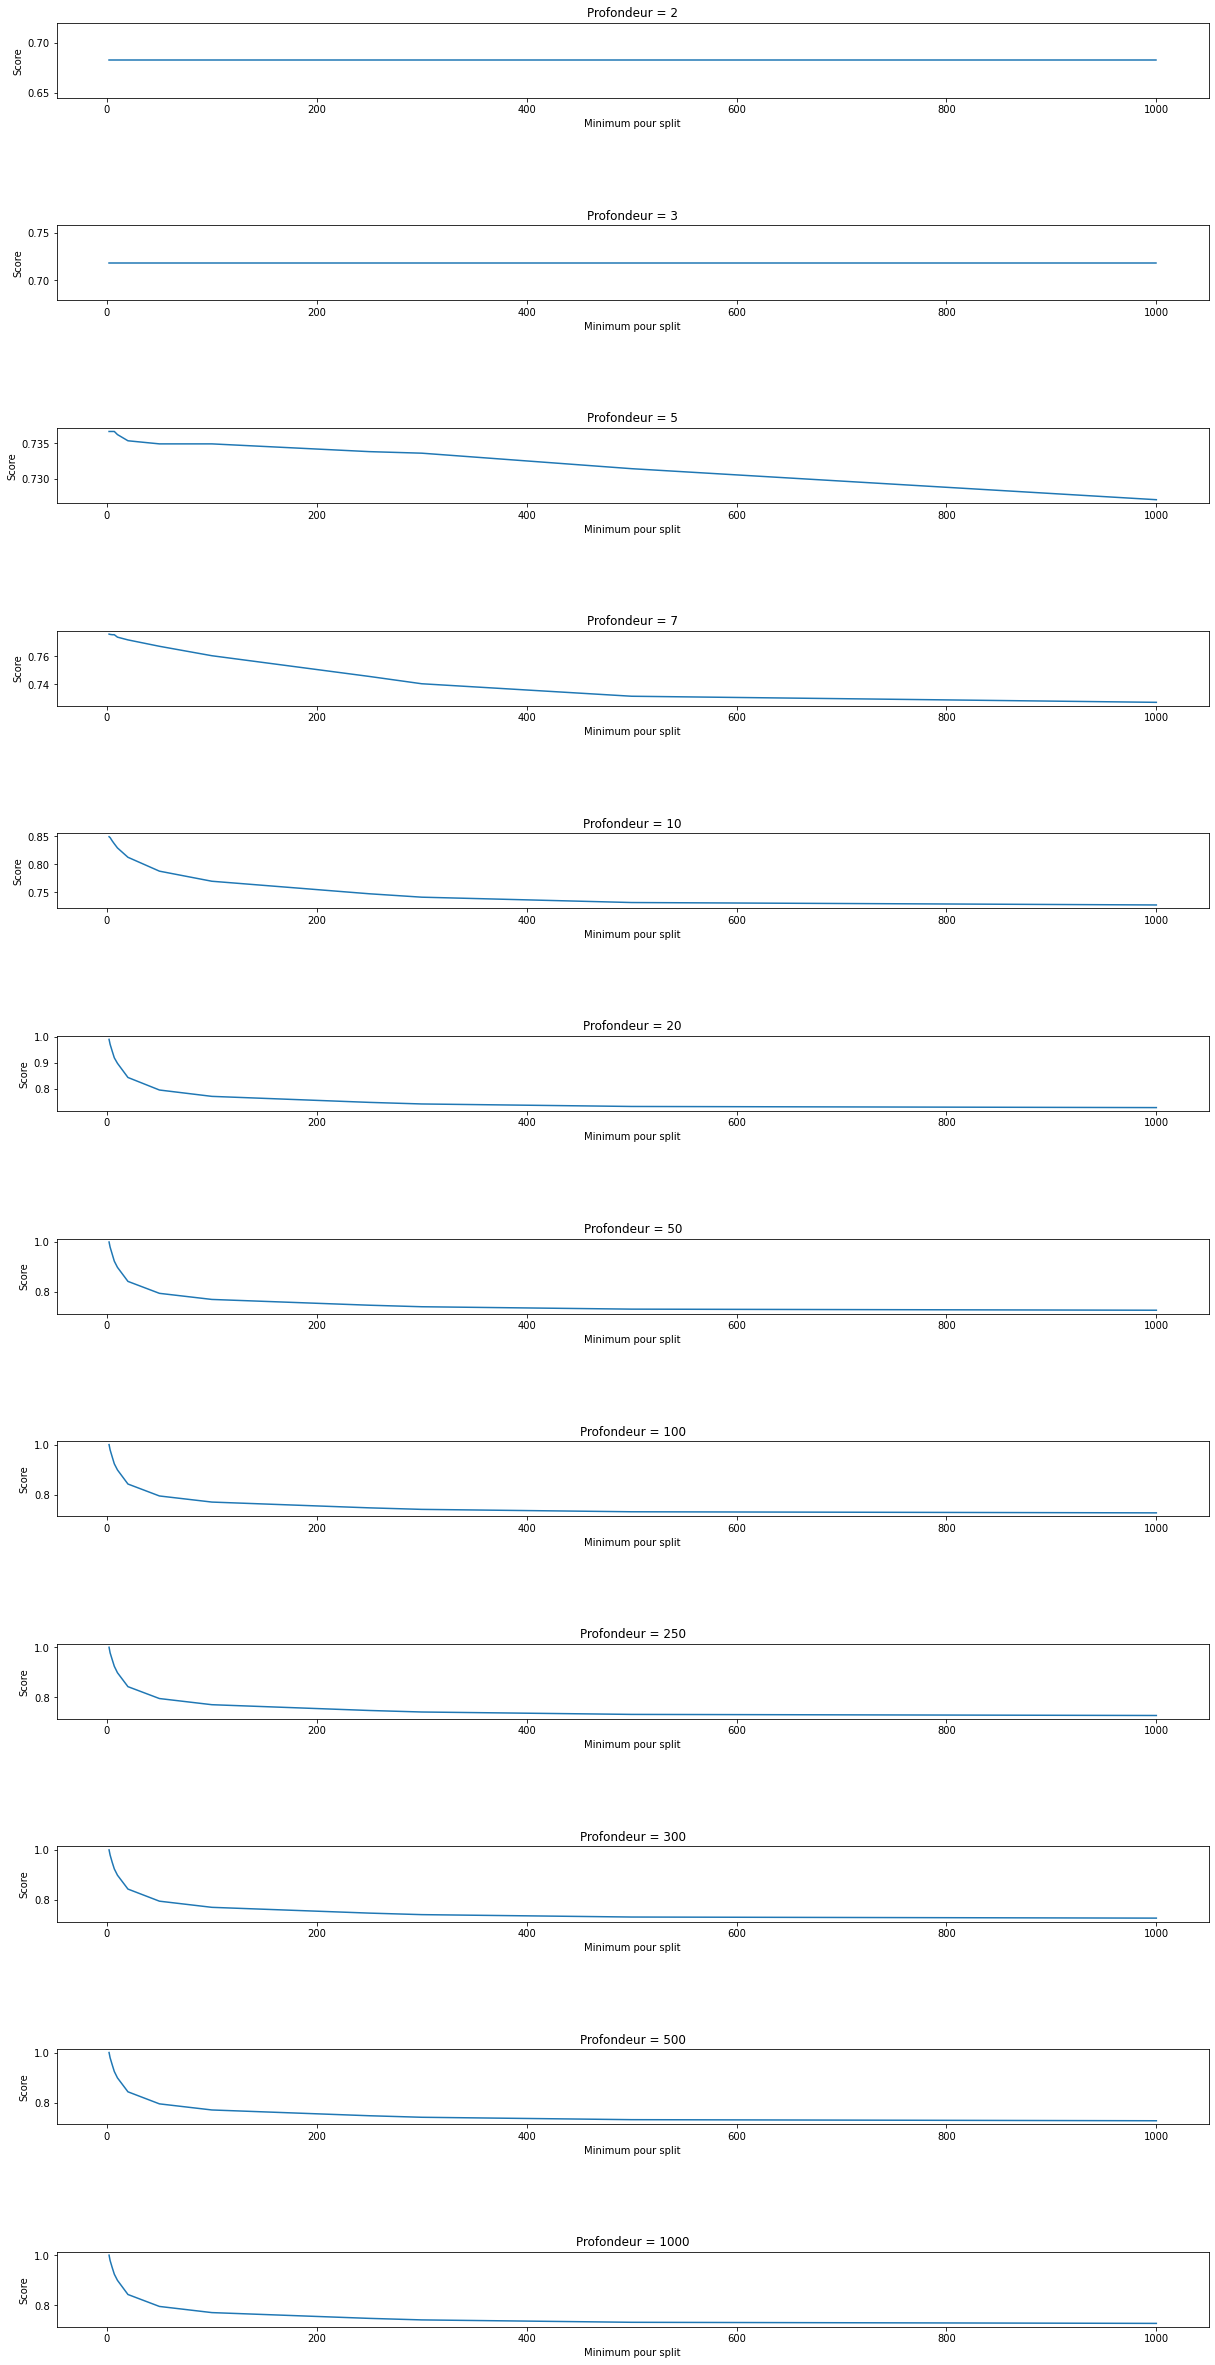

In [10]:
list_max_depth = [2,3,5,7,10,20,50,100,250,300,500,1000]
list_min_samples_split = [2,3,5,7,10,20,50,100,250,300,500,1000]
list_sco = []
for max_depth in list_max_depth:
    sco_temps = []
    for min_samples_split in list_min_samples_split :
        #print("---------------------------")
        #print(f"max_depth ={max_depth}\nmin_samples_split={min_samples_split} ")
        dt = learn_tree(datax,datay,id2genre,max_depth,min_samples_split,save=False)
        #print(dt.score(datax,datay))
        sco_temps.append(dt.score(datax,datay))
    list_sco.append(sco_temps)

fig, ax = plt.subplots(len(list_max_depth),figsize=(20,40))
for i in range(len(list_max_depth)):
    ax[i].plot(list_min_samples_split,list_sco[i])
    ax[i].set_title(f'Profondeur = {list_max_depth[i]}')
    ax[i].set_xlabel('Minimum pour split')
    ax[i].set_ylabel('Score')
    
plt.subplots_adjust(left=0.1, bottom=0.1,  right=0.9,  top=0.9,  wspace=0.4,  hspace=1.7) 

# Observations:
    Q1.4, Q1.5 et Q1.6:

## Que remarquez-vous quant au nombre d’exemples séparés à chaque niveau en fonction de la profondeur ? est-ce normal ?
       En comparant les arbres selon les différentes profondeurs, on remarque que la taille est divisé par deux à chaque niveau, ce qui est normale sachant que nous sommes dans des arbres binaires.

## Comment évoluent les scores de bonne classification en fonction de la profondeur ? Est-ce normal ?
       Le taux de bonne classification de l'arbre augmente avec sa profondeur, ce qui est normal: on se permet de diviser les noeuds de niveau inférieur à max_depth, sous réserve que leur nombre d'exemples est supérieur à min_samples_split (2 ici). Le problème, c'est que bien souvent pour une profondeur trop grande, la condition d'arrêt sur min_samples_split est atteinte avant la condition de profondeur: on se retrouve alors avec beaucoup de feuilles qui correspondent à 2 exemples bien précis, on est en situation de sur-apprentissage.
       Plus la valeur de la profondeur augmente, plus il y a de feuille et donc plus on est en sur-apprentissage.

## Ces scores sont-ils un indicateur fiable du comportement de l’algorithme ? Comment obtenir un indicateur plus fiable ?
       On sait que le score de classification est calculé sur les données d'apprentissage (datax et datay), et est donc complètement biaisé(et n'est donc pas fiable). Pour des données autres que celles de datax, le taux de bonne classification serait moins bon. Pour ce faire, une solution est de separer les données en deux ensembles pour learn et test.

### Q1.7

In [11]:

for test_size in [0.2,0.5,0.8] :
    X_train,X_test,y_train,y_test = train_test_split(datax,datay,test_size=test_size,random_state=1)
    dt.fit(X_train, y_train)  
    y_pred = dt.predict(X_test)
    print("size test:",test_size)
    print("classifieur:",accuracy_score(y_test,y_pred)) 


size test: 0.2
classifieur: 0.6840958605664488
size test: 0.5
classifieur: 0.6830863121185702
size test: 0.8
classifieur: 0.570299727520436


### Q1.8

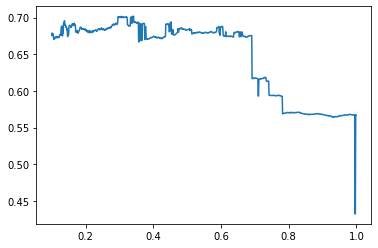

In [12]:
list_size = []
list_score = []
for test_size in np.arange(0.1,1.0,0.001) :
    X_train,X_test,y_train,y_test = train_test_split(datax,datay,test_size=test_size,random_state=1)
    dt.fit(X_train, y_train)  
    y_pred = dt.predict(X_test)
    sco = accuracy_score(y_test,y_pred)
    #print("size test:",test_size)
    #print("classifieur:",sco) 
    list_size.append(test_size)
    list_score.append(sco)

plt.plot(list_size,list_score)

## Q1.9: Vos résultats vous semblent ils fiables et stables ? Comment les améliorer ?
    Vu le peu de donnée qu'on a, les résultats ne vont pas être très fiable avec n'importe quelle partition.
    Une amélioration possible serait d'utiliser la validation croisée.

# Validation croisée: sélection de modèles


Pour sélectionner un modèle tout en considérant le plus grand nombre d’exemples possibles pour l’apprentissage, on utilise généralement une procédure dite de sélection par validation croisée. Cette procédure est implémentée ci-dessous, et calcule les erreurs moyennes de classification pour une n-partition, selon la profondeur de l'arbre de décisions.

In [14]:
#liste_x = range(2,100,2)
#liste_mean = []
#liste_std = []

#for i in liste_x :
#    scores = cross_val_score(dt,datax,datay)
#    liste_mean.append(scores.mean())
#   liste_std.append(scores.std())
#print(f"La moyenne est de {scores.mean():.3f} et l'écart type et de {scores.std():.3f}.")




NameError: name 'KFold' is not defined

In [ ]:
plt.plot(liste_x,liste_mean)
plt.title(f"Mean")
plt.xlabel("Nombre d'iteration dans cross val")
plt.ylabel('Score')

In [ ]:
plt.plot(liste_x,liste_std)
plt.title(f"Std")
plt.xlabel("Nombre d'iteration dans cross val")
plt.ylabel('Score')